In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme('paper',style='white',font_scale=1.25)
import math
import random
import matplotlib
from os.path import join,exists
import os
import cv2

This jupyter noteboook should support article: Magnetic microrheometry of tumor-relevant stiffness levels and heterogeneity in viscoelasticity inside 3D cell culture matrices

- You can use this to reproduce all figures shown in the article after downloading data:

Data is available from [dropbox](https://www.dropbox.com/sh/uw8l7ne84guyrfg/AAATW3DDnIwKkotkmr9UX6KSa?dl=0)
Link: https://www.dropbox.com/sh/uw8l7ne84guyrfg/AAATW3DDnIwKkotkmr9UX6KSa?dl=0

In addition:


-Microrheology data can be found from material spesifc .csv inside "microdata"
-Macrorheology data can be found from material spsific .csv inside "macrodata"

-./simulation folder contains comsol simulation used to simulated magnetic field. The folder contains two version of the simulation 1) permeability is taken from the B-H curve of the material. 2) permeability is taken from a constant. In the paper we used 1) to create the plots. However, the simulation is highly non-linear and computationally expensive. Also, the number of current loops in the simulation is overestimated, but we saw no reason optimize computational time here.

In [3]:
#change this to correspond the folder you downloaded data
data_folder = "C:/Users/lehtona6/Dropbox (Aalto)/ArttuFolder_PokkiLab/Shared_Materials/ExampleData"

######
#Micro
######

#100µm Agarose
Agarose = pd.read_csv(os.path.join(data_folder,"microdata/Agarose_100_track_ID_summary.csv"))

#30µm Agarose
low_Agarose = pd.read_csv(os.path.join(data_folder,"microdata/Agarose_30_track_ID_summary.csv"))

#GD-Col
GD_COL = pd.read_csv(os.path.join(data_folder,"microdata/GrowDex-Collagen_track_ID_summary.csv"))

#GD
GD = pd.read_csv(os.path.join(data_folder,"microdata/GrowDex_track_ID_summary.csv"))

#Fibrin
Fibrin = pd.read_csv(os.path.join(data_folder,"microdata/Fibrin_track_ID_summary.csv"))

#Heterogenity esitmation data frame
hetero_gen = pd.concat([GD,GD_COL,Fibrin,low_Agarose])
hetero_gen = hetero_gen[(hetero_gen["concentration"] == 1.25) | (hetero_gen["concentration"] == "0.45/2") | (hetero_gen["concentration"] == 30) | (hetero_gen["type"] == "Agarose")]

######
# Macro
######

#Agarose
M_Ag = pd.read_csv(os.path.join(data_folder,"macrodata/Agarose_MacrorheologyRev.csv"))
M_Ag = M_Ag[M_Ag["particle_condition"] == 1]
M_Ag = M_Ag.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})
M_Ag["concentration %"] = round(M_Ag["concentration %"]*10,2)
M_Ag.loc[M_Ag["concentration %"] == 1.2,"concentration %"] = 1.25
M_Ag.loc[M_Ag["concentration %"] == 1.3,"concentration %"] = 1.35

M_AgHet = pd.read_csv(os.path.join(data_folder,"macrodata/Agarose_MacrorheologyHet.csv"))
M_AgHet["Phase Shift Angle"] = np.arctan((M_AgHet["Loss Modulus"])/(M_AgHet["Storage Modulus"]))
M_AgHet = M_AgHet.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})

# GD
M_GD = pd.read_csv(os.path.join(data_folder,"macrodata/Growdex_Macrorheology.csv"))
M_GD = M_GD[M_GD["concentration"] == 1.25]

M_GD["Time"] = np.array(M_GD["Time"]/60).astype("int")

M_GD = M_GD.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})

# GD-Col
M_GD_col = pd.read_csv(os.path.join(data_folder,"macrodata/Growdex_collagen_Macrorheology.csv"))
M_GD_col = M_GD_col[M_GD_col["concentration"] == 0.45]
M_GD_col = M_GD_col.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})

M_Fib = pd.read_csv(os.path.join(data_folder,"macrodata/FibrinMacro.csv"))
M_Fib = M_Fib.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})

M_GD["type"] = "GrowDex"; M_GD["concentration %"] = "1.25%"

M_GD_col["type"] = "GrowDex-Collagen"; M_GD_col["concentration %"] = "0.45%/2mg/ml"

M_AgHet["type"] = "Agarose"; M_AgHet["concentration %"] = "0.5%"

M_Fib["type"] = "Fibrin"; M_Fib["concentration %"] = "30mg/ml"

M_Fib["Complex Shear Modulus (Pa)"] = np.sqrt(M_Fib["Storage Modulus"]**2 + M_Fib["Loss Modulus"]**2)

hetero_macro  = pd.concat([M_GD,M_GD_col,M_AgHet,M_Fib])

# Particle comparison
comp = pd.read_csv(os.path.join(data_folder,"macrodata/Agarose_MacrorheologyParticleComp.csv"))
comp = comp.rename(columns={'concentration':'concentration %',
                              'Complex Shear Modulus':'Complex Shear Modulus (Pa)',
                              'Time':'Time (min)',
                              'Phase Shift Angle': 'Phase Shift Angle (Pa)'})

comp.loc[comp["concentration %"] == 0.09,"concentration %"] = np.array(comp.loc[comp["concentration %"] == 0.09,"concentration %"].values)*10

In [4]:

#Saves the plot
def saver(fig,name):
    data_folder = "C:/Users/lehtona6/projects/work/microrheology/visualization"
    res_path = join(data_folder,"results/" + name)
    fig.savefig(res_path,transparent=False,facecolor='white' )

#plots micro
def plotter(data_in,x_data,y_data,x_label,y_label,ax_in,letter,scientific = False,ylim=False):
    sns.swarmplot(ax = ax_in,x=x_data,y=y_data,data=data_in,size=5,color='black',alpha=0.5)
    sns.boxplot(ax = ax_in,x=x_data,y=y_data,data=data_in,color = "white", showmeans = True,meanprops={
                        "marker":"s",
                        "markerfacecolor":"red", 
                        "markeredgecolor":"red",
                        "markersize":"7",
                        "alpha":1.0})
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.text(-0.1, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.tick_params(labelsize=9)
    if scientific:    
        ax_in.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
    if ylim:
        ax_in.set_ylim(ylim)
    return ax_in  



#plots macro |G|
def plot_macro_g(data,ax_in,letter,x_label,y_label,hueParam,vline=True,log=True):
    sns.lineplot(ax = ax_in, data=data,x='Time (min)',y='Complex Shear Modulus (Pa)',hue=hueParam,
                palette=sns.color_palette('bright',data['concentration %'].unique().shape[0]), legend = False)
    ax_in.text(-0.09, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.tick_params(labelsize=9)
    if vline:
        ax_in.axvline(50,color='black',linestyle='--')
    if log:
        #ax.set_yscale('log')
        ax_in.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax_in.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
        #ax_in.legend(title = r"Concentration [$\%$]",loc='upper left',fontsize = 9)
        #ax_in.legend()

    return ax_in

#plots macro phi
def plot_macro_phi(data,ax_in,letter,x_label,y_label,hueParam,vline=True,log=False,ae=True): #type #concentration %
    sns.lineplot(ax = ax_in, data=data,x='Time (min)',y='Phase Shift Angle (Pa)',hue=hueParam,
                palette=sns.color_palette('bright',data['concentration %'].unique().shape[0]))
    ax_in.text(-0.1, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.tick_params(labelsize=9)
    ax_in.set_xlim([0,90])
    if vline:
        ax_in.axvline(50,color='black',linestyle='--')
    if log:
        ax_in.set_yscale('log')
        ax_in.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax_in.ticklabel_format(axis='y',style='plain', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
        #ax_in.legend(title = r"Concentration [$\%$]",loc='upper left',fontsize = 9)
        ax_in.legend(title = r"Material",loc='upper left',fontsize = 9)
    if ae:
        plt.ylim([0,10])
        
    return ax_in

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 26.3% of the points 

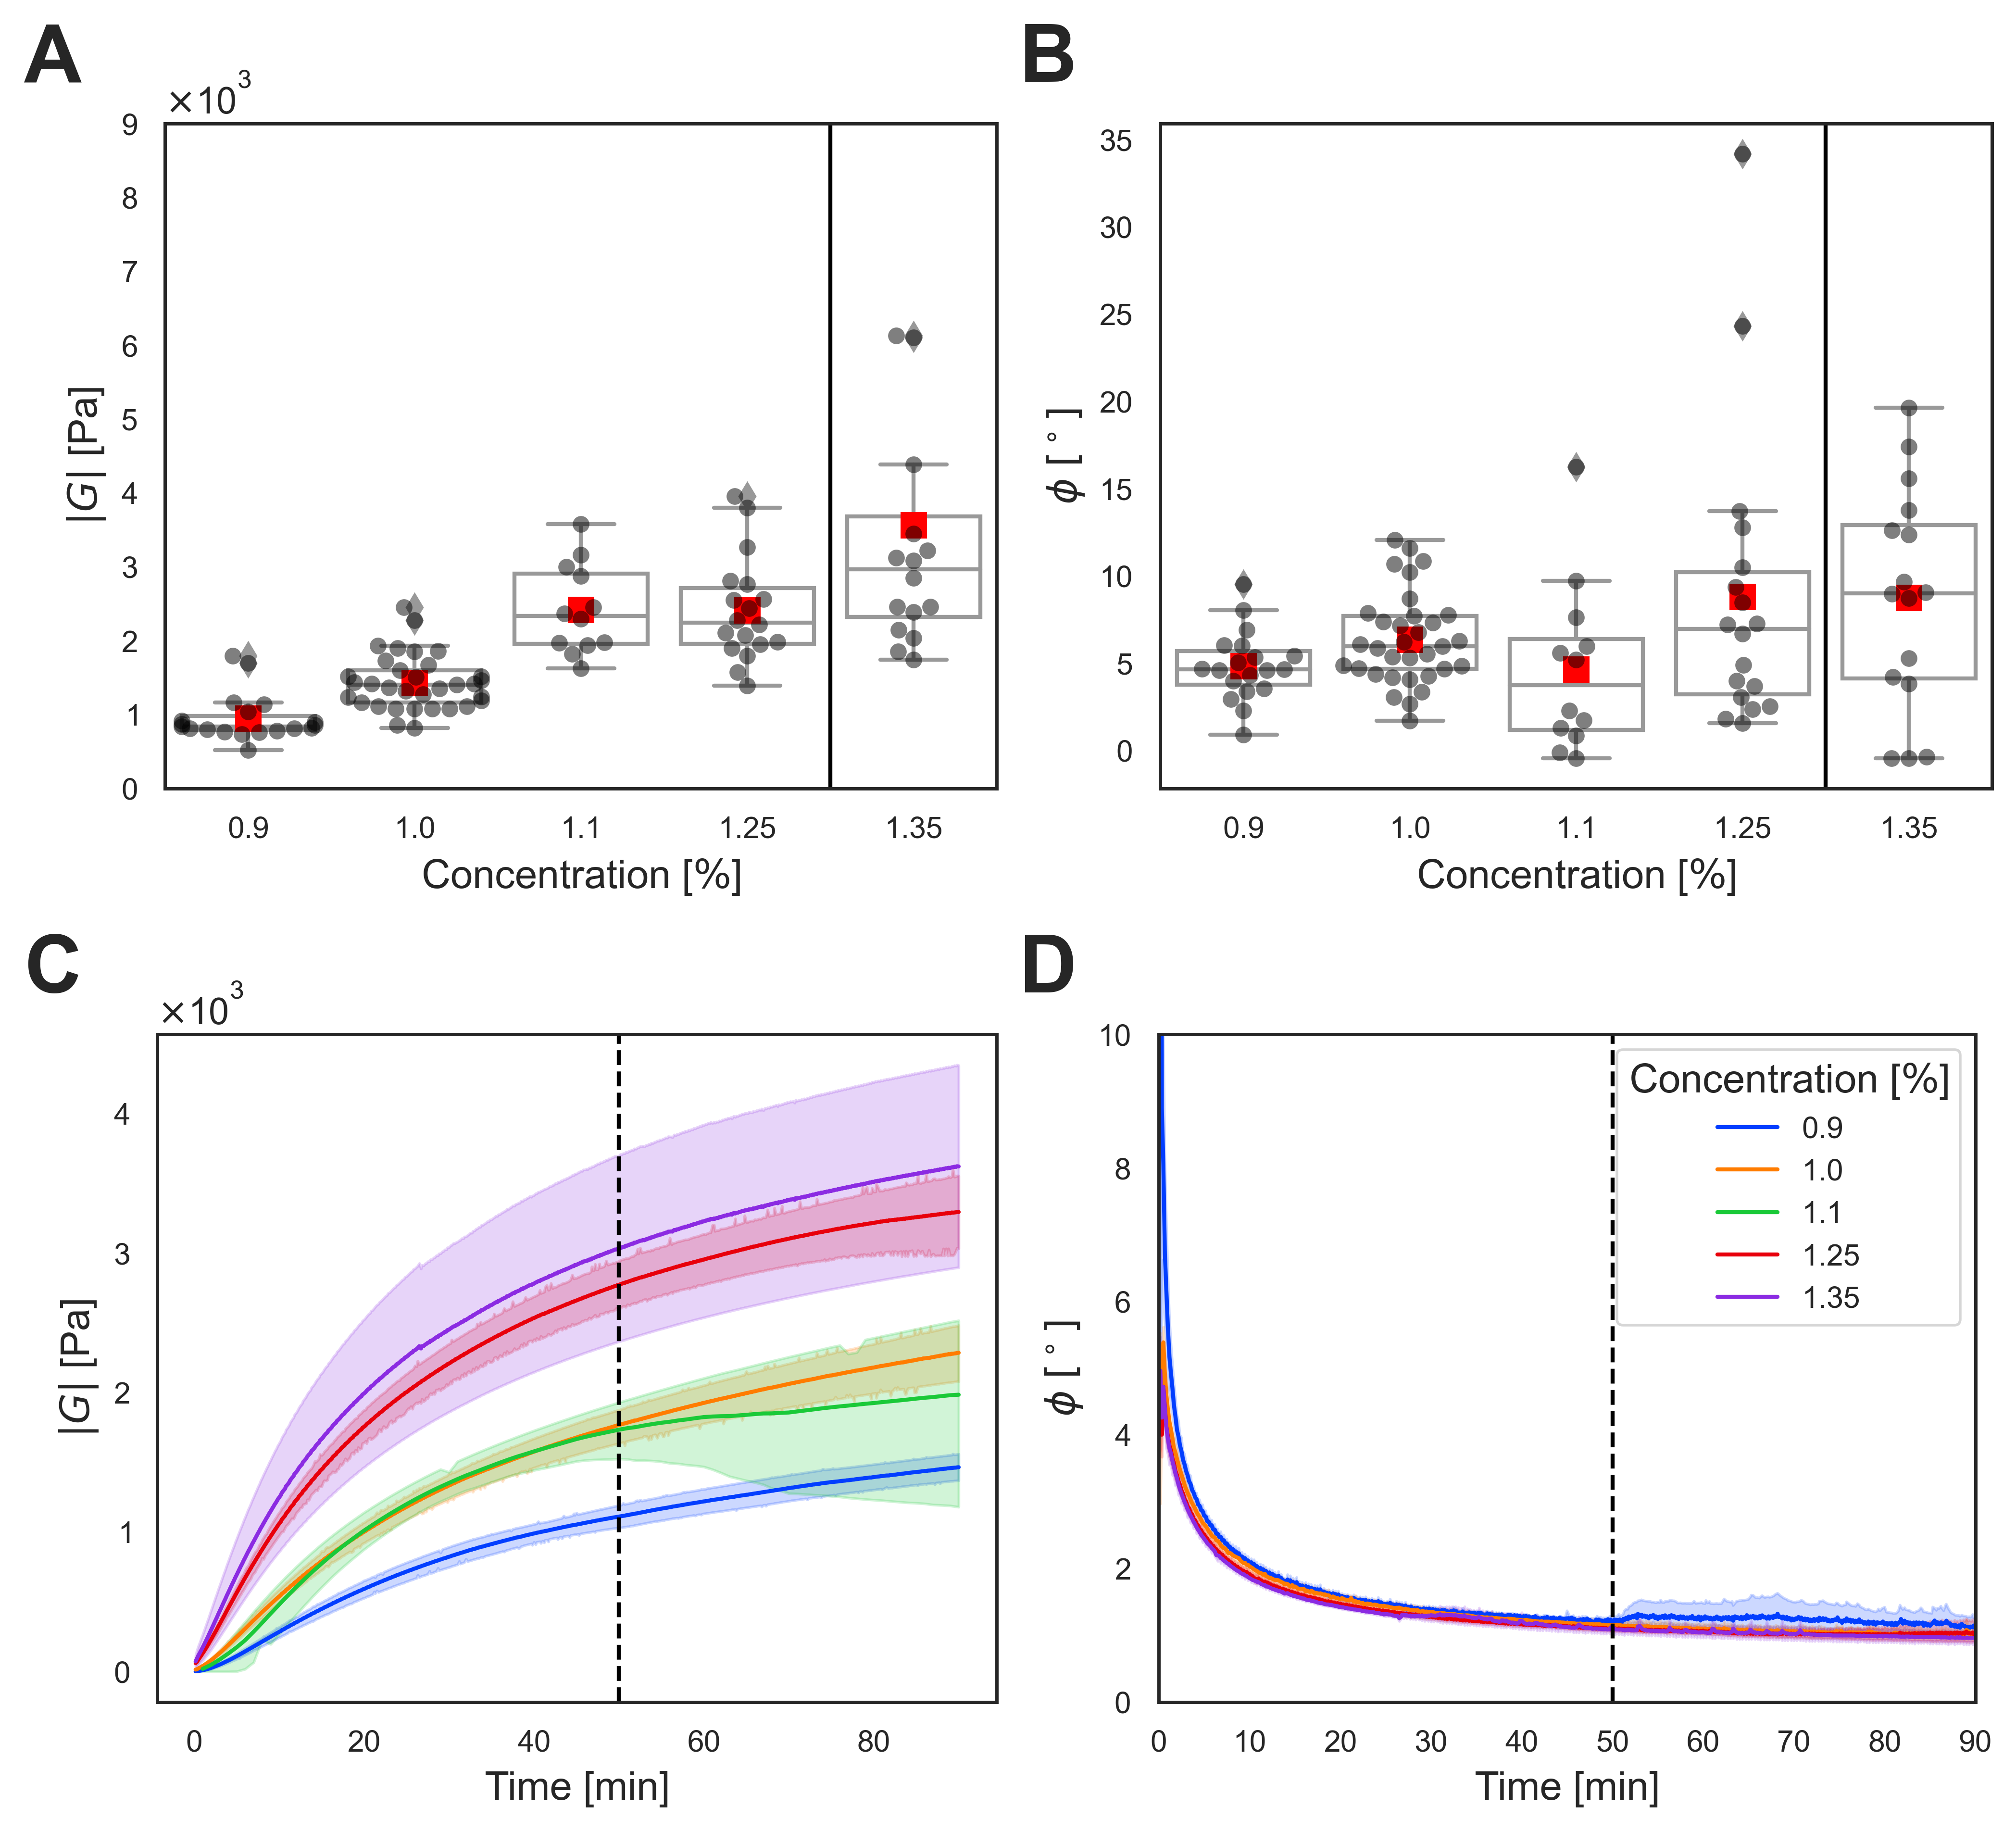

In [18]:
#Agarose 100µm microrheology

fig = plt.figure(constrained_layout=True, figsize=(8.27, 7.5),dpi = 500)
subfigs = fig.subfigures(2, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0,0].subplots(1, 1)
ax2 = subfigs[0,1].subplots(1, 1)
ax3 = subfigs[1,0].subplots(1, 1)
ax4 = subfigs[1,1].subplots(1, 1)

#Agarose macrorheology 

ax1 = plotter(Agarose, "sample", "G_abs",r"Concentration [$\%$]",r'$|G|$ [Pa]',ax1,"A",True)
ax1.axvline(3.5,color='black',linestyle='-')
ax1.set_ylim([0,9e3])
ax2 = plotter(Agarose, "sample", "phi_(deg)",r"Concentration [$\%$]",r"$\phi$ $[^\circ]$",ax2,"B")
ax2.axvline(3.5,color='black',linestyle='-')
ax3 = plot_macro_g(M_Ag,ax3,"C","Time [min]","$|G|$ [Pa]","concentration %",vline=True,log=True)
ax4 = plot_macro_phi(M_Ag,ax4,"D","Time [min]",r"$\phi$ $[^\circ]$","concentration %",vline=True,log=False, ae = True)
ax4.legend(title=r'Concentration [$\%$]',loc='upper right',fontsize = 9)
saver(fig,"high_stiffness.png")
plt.show()

In [17]:
print(Agarose.groupby("sample")["G_abs","phi_(deg)"].agg(["mean","std"]))

              G_abs              phi_(deg)          
               mean          std      mean       std
sample                                              
0.90     949.328192   316.271073  4.847353  1.977577
1.00    1433.952529   372.593639  6.344201  2.592010
1.10    2421.810704   608.475732  4.658428  4.869317
1.25    2412.156207   703.108800  8.798625  8.464983
1.35    3567.788909  2101.588770  8.738779  6.343791


<ipython-input-17-1e99a228aeca>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(Agarose.groupby("sample")["G_abs","phi_(deg)"].agg(["mean","std"]))


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 5.6% of the points 

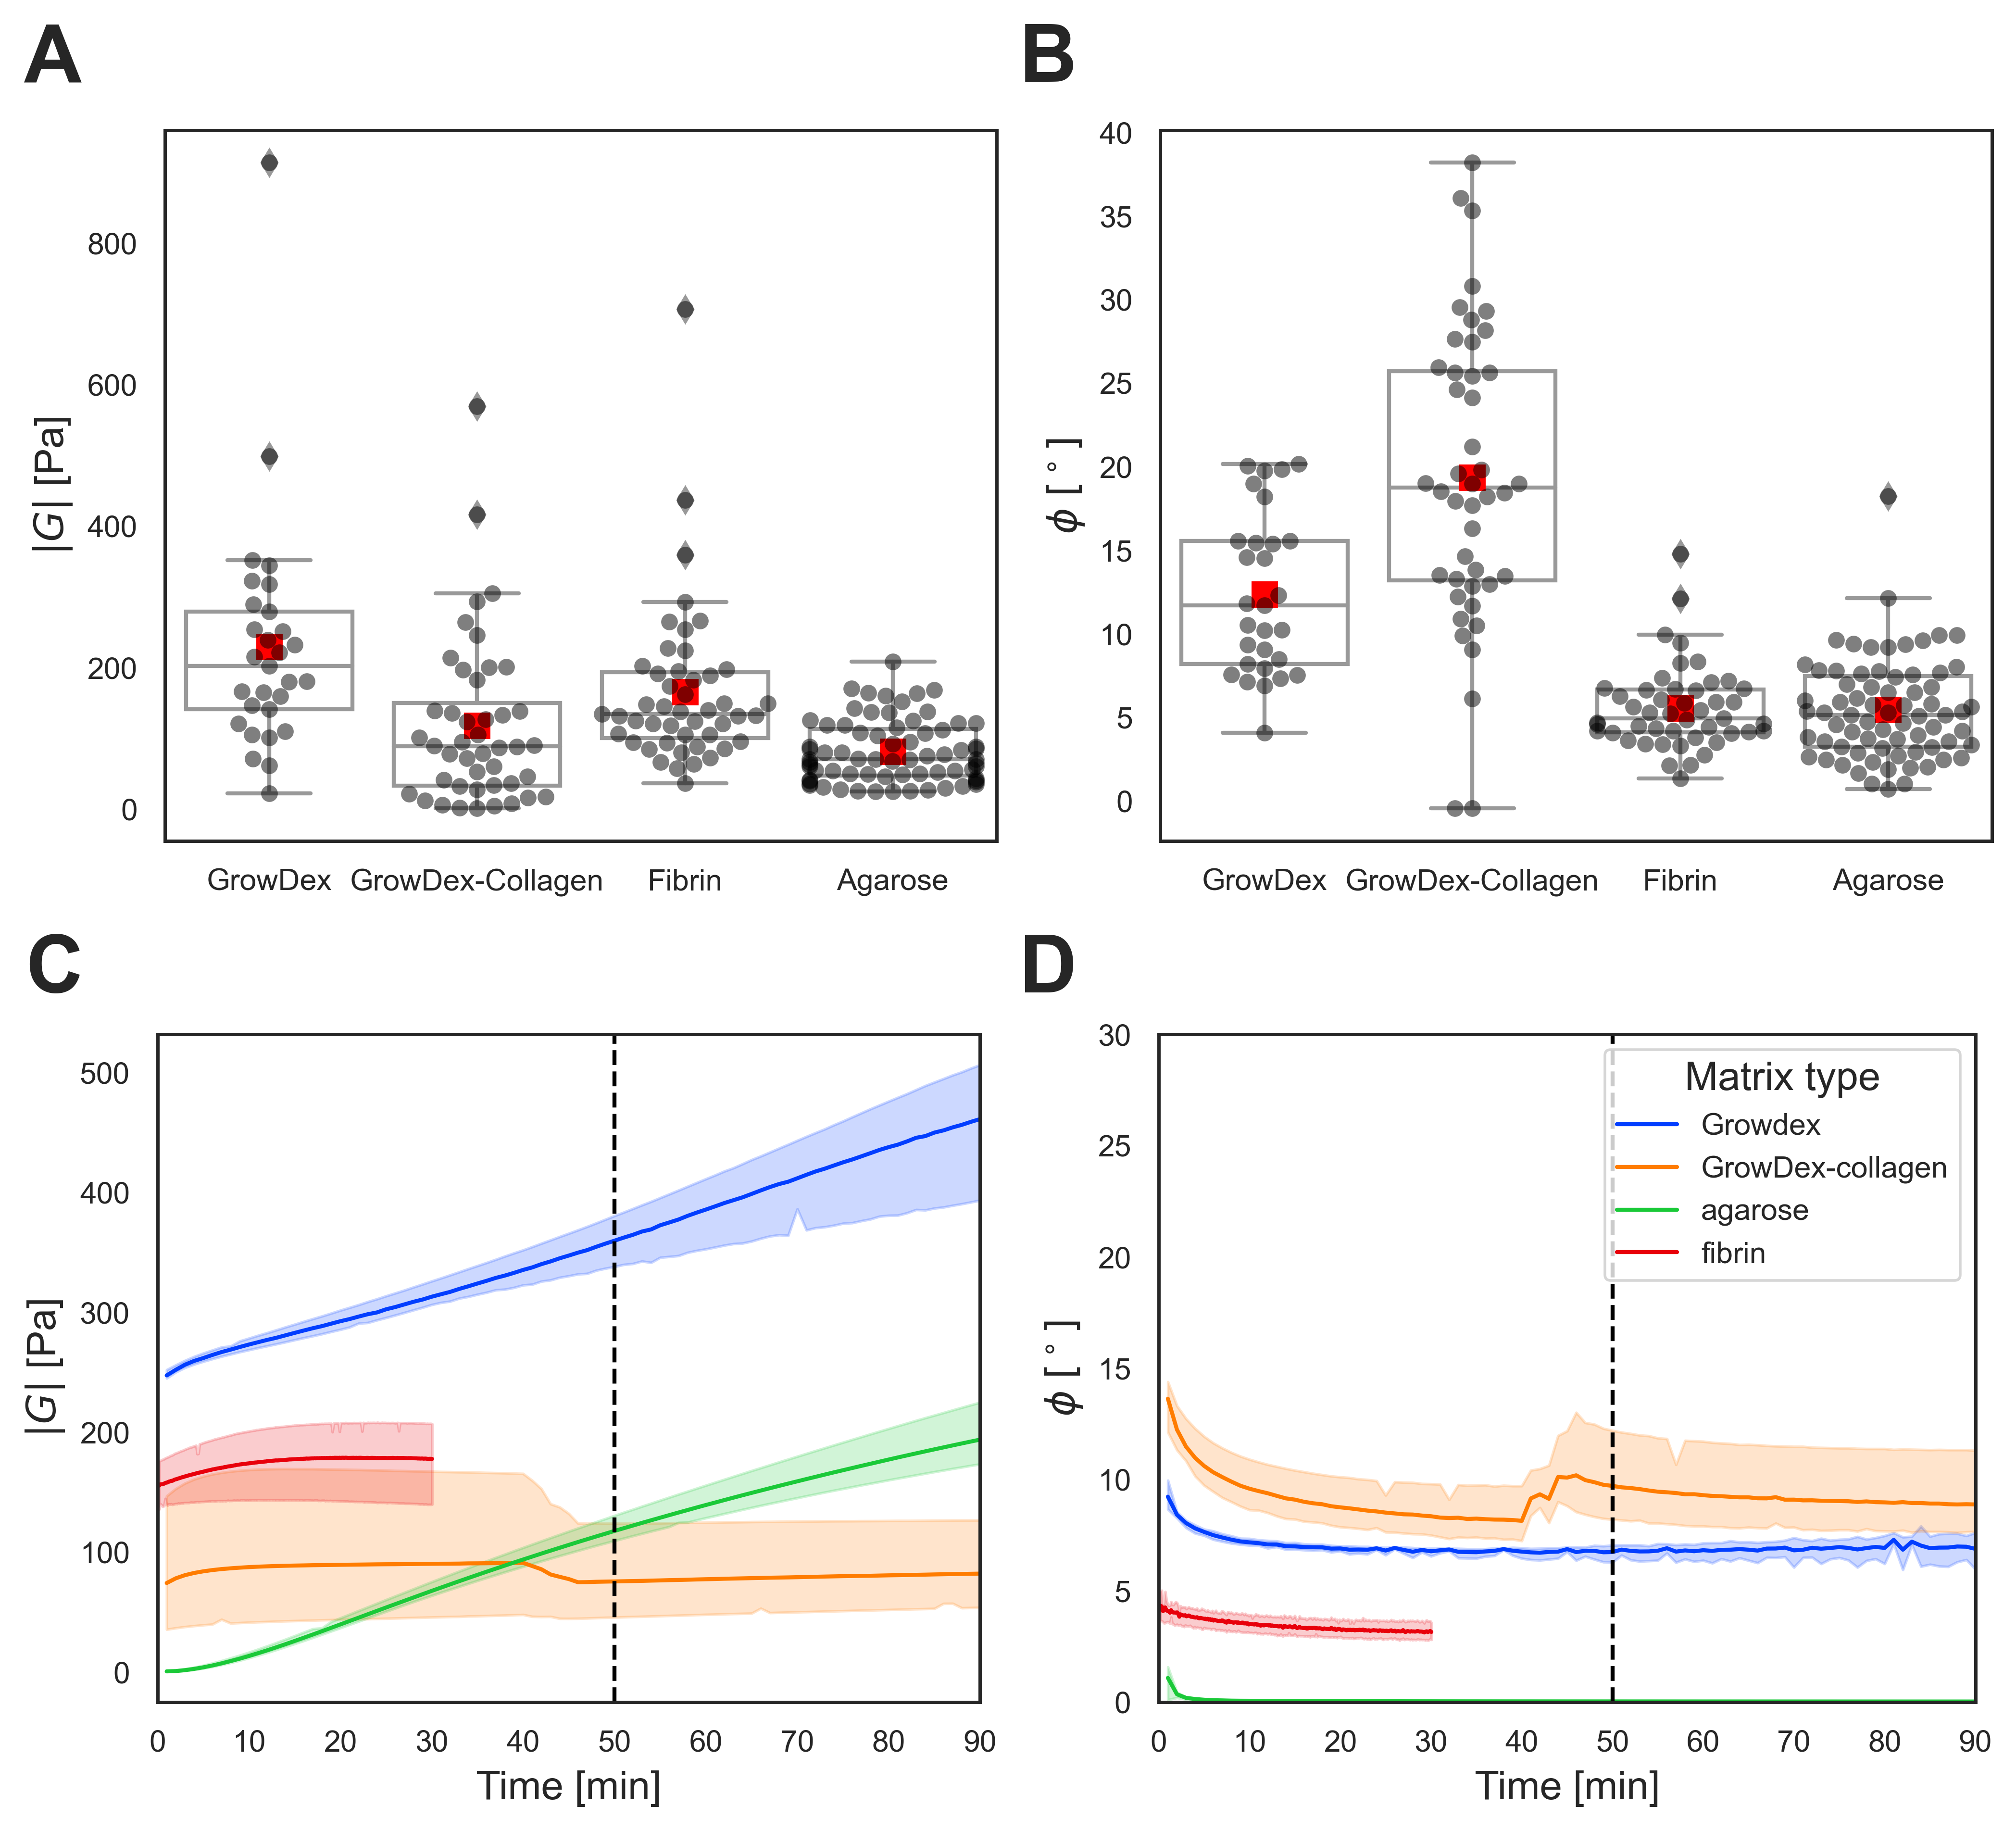

In [17]:
#Agarose 30µm microrheology

fig = plt.figure(constrained_layout=True, figsize=(8.27, 7.5),dpi = 500)
subfigs = fig.subfigures(2, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0,0].subplots(1, 1)
ax2 = subfigs[0,1].subplots(1, 1)
ax3 = subfigs[1,0].subplots(1, 1)
ax4 = subfigs[1,1].subplots(1, 1)

#Agarose macrorheology 

ax1 = plotter(hetero_gen, "type", "G_abs",r"",r'$|G|$ [Pa]',ax1,"A")
ax2 = plotter(hetero_gen, "type", "phi_(deg)",r"",r"$\phi$ $[^\circ]$",ax2,"B",False,False)

ax3 = plot_macro_g(hetero_macro,ax3,"C","Time [min]","$|G|$ [Pa]","type",vline=True,log=False)
ax4 = plot_macro_phi(hetero_macro,ax4,"D","Time [min]",r"$\phi$ $[^\circ]$","type",vline=True,log=False, ae = False)
ax3.set_xlim([0,90])
ax4.set_xlim([0,90])
ax4.set_ylim([0,30])
ax4.legend(ax4.get_legend_handles_labels()[0], ["Growdex", "GrowDex-collagen", "agarose","fibrin"],title='Matrix type',loc='upper right',fontsize = 9)

saver(fig,"HeteroGenComp.png")
plt.show()


In [15]:
print(hetero_gen.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"]))

                       G_abs              phi_(deg)          
                        mean         std       mean       std
type                                                         
Agarose            80.794640   44.085980   5.458549  3.006753
Fibrin            165.093098  112.869324   5.550984  2.497439
GrowDex           229.496530  166.956806  12.359034  4.780554
GrowDex-Collagen  117.663193  117.546940  19.347722  8.905707


<ipython-input-15-284ee3428725>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(hetero_gen.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"]))


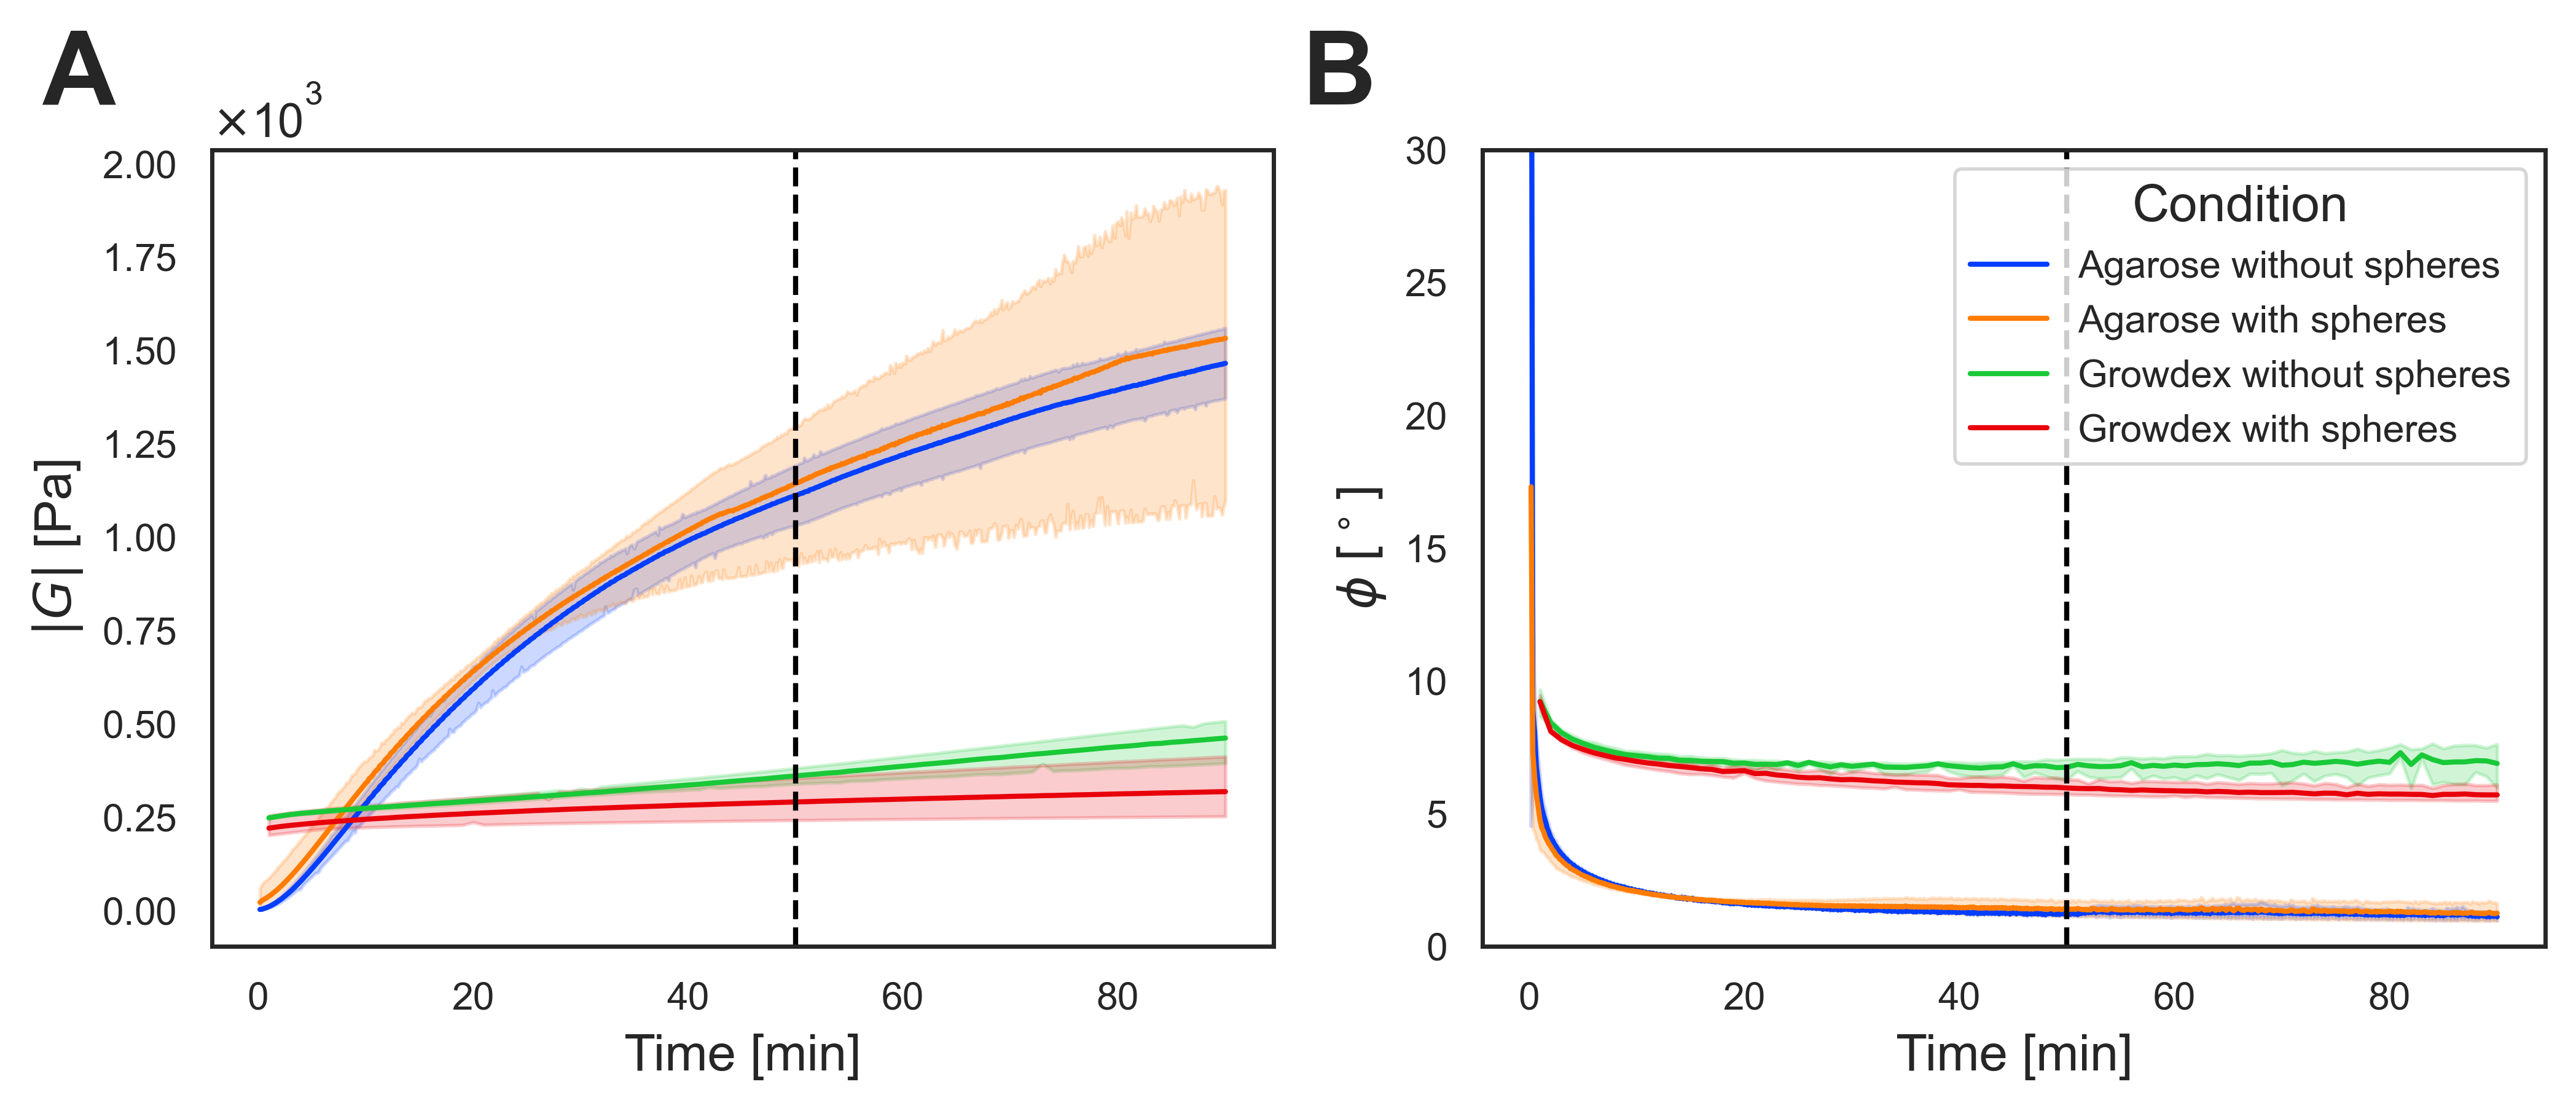

In [20]:
#Agarose 0.9% and growdex particle comparison
comp.loc[(comp["particle_condition"] == 0) & (comp["concentration %"] == comp["concentration %"].unique()[0]),"particle_condition"] = "agarose with spheres"
comp.loc[(comp["particle_condition"] == 1) & (comp["concentration %"] == comp["concentration %"].unique()[0]),"particle_condition"]= "agarose without spheres"
         
comp.loc[(comp["particle_condition"] == 0) & (comp["concentration %"] == comp["concentration %"].unique()[1]),"particle_condition"] = "Growdex with spheres"
comp.loc[(comp["particle_condition"] == 1) & (comp["concentration %"] == comp["concentration %"].unique()[1]),"particle_condition"] = "Growdex without spheres"

fig = plt.figure(constrained_layout=True, figsize=(8.27, 3.5),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)

sns.lineplot(ax = ax1, data=comp,x='Time (min)',y='Complex Shear Modulus (Pa)',hue='particle_condition',
            palette=sns.color_palette('bright',comp['particle_condition'].unique().shape[0]), legend = False)
ax1.text(-0.09, 1.15, "A", transform=ax1.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax1.set_xlabel("Time [min]", fontsize=12)
ax1.set_ylabel("$|G|$ [Pa]", fontsize=12)
ax1.tick_params(labelsize=9)
ax1.axvline(50,color='black',linestyle='--')
#ax.set_yscale('log')
ax1.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax1.yaxis.major.formatter._useMathText = True

sns.lineplot(ax = ax2, data=comp,x='Time (min)',y='Phase Shift Angle (Pa)',hue='particle_condition',
            palette=sns.color_palette('bright',comp['particle_condition'].unique().shape[0]))
ax2.text(-0.1, 1.15, "B", transform=ax2.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax2.set_xlabel("Time [min]", fontsize=12)
ax2.set_ylabel(r"$\phi$ $[^\circ]$", fontsize=12)
ax2.set_ylim([0,30])
ax2.tick_params(labelsize=9)
ax2.axvline(50,color='black',linestyle='--')
ax2.legend(title = r"Condition",loc='upper right',fontsize = 9)


saver(fig,"particleComp.png")
plt.show()

In [19]:
# Create the collection of macrorheomeasurements, calculate: mean, std, and CoV

dfMean = hetero_macro.groupby(["type","concentration %","Time (min)"]).mean().reset_index()
dfStd = hetero_macro.groupby(["type","concentration %","Time (min)"]).std().reset_index()

AgMean = [dfMean.loc[(dfMean["Time (min)"] == 50) & (dfMean["type"] == "Agarose")],dfStd.loc[(dfStd["Time (min)"] == 50) & (dfStd["type"] == "Agarose")]]
GDMean = [dfMean.loc[(dfMean["Time (min)"] == 50) & (dfMean["type"] == "GrowDex")],dfStd.loc[(dfStd["Time (min)"] == 50) & (dfStd["type"] == "GrowDex")]]
GDColMean = [dfMean.loc[(dfMean["Time (min)"] == 50) & (dfMean["type"] == "GrowDex-Collagen")],dfStd.loc[(dfStd["Time (min)"] == 50) & (dfStd["type"] == "GrowDex-Collagen")]]
FibrinMean = [dfMean.loc[(dfMean["Time (min)"] > 30) & (dfMean["type"] == "Fibrin")],dfStd.loc[(dfStd["Time (min)"] > 30) & (dfStd["type"] == "Fibrin")]]

df3 = hetero_macro.groupby(["type","concentration %","Time (min)"])["Complex Shear Modulus (Pa)","Phase Shift Angle (Pa)"].agg(["mean","std"]).reset_index()
dfTable = pd.concat([df3.loc[df3["Time (min)"] == 50.0],df3.loc[(df3["Time (min)"] > 30) & (df3["type"] == "Fibrin")]])
dfTable = dfTable.drop(["Time (min)","concentration %"], axis = 1)
dfTable["Coef of variation G"] =  dfTable["Complex Shear Modulus (Pa)"]["std"]/dfTable["Complex Shear Modulus (Pa)"]["mean"]
dfTable["Coef of variation phi"] =  dfTable["Phase Shift Angle (Pa)"]["std"]/dfTable["Phase Shift Angle (Pa)"]["mean"]
print(dfTable.to_latex(index=True))

#change 2 decimals

\begin{tabular}{llrrrrrr}
\toprule
{} &              type & \multicolumn{2}{l}{Complex Shear Modulus (Pa)} & \multicolumn{2}{l}{Phase Shift Angle (Pa)} & Coef of variation G & Coef of variation phi \\
{} &                       mean &        std &                   mean & \multicolumn{3}{l}{std} \\
\midrule
49  &           Agarose &                 117.626667 &  11.218272 &               0.023751 &  0.000573 &            0.095372 &              0.024118 \\
370 &           GrowDex &                 359.690000 &  21.255595 &               6.736667 &  0.402534 &            0.059094 &              0.059753 \\
460 &  GrowDex-Collagen &                  75.526333 &  42.366993 &               9.710000 &  2.172625 &            0.560957 &              0.223751 \\
320 &            Fibrin &                 177.694883 &  34.388346 &               3.145667 &  0.385350 &            0.193525 &              0.122502 \\
\bottomrule
\end{tabular}



<ipython-input-19-de909b29c23c>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df3 = hetero_macro.groupby(["type","concentration %","Time (min)"])["Complex Shear Modulus (Pa)","Phase Shift Angle (Pa)"].agg(["mean","std"]).reset_index()
<ipython-input-19-de909b29c23c>:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfTable = dfTable.drop(["Time (min)","concentration %"], axis = 1)
<ipython-input-19-de909b29c23c>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfTable.to_latex(index=True))


In [20]:
##Supplementary table of all microrheology measurements

Agarose_mm = Agarose
Agarose_mm["type"] = 0
hetero_gen.loc[hetero_gen["type"]=="Agarose","type"] = "Agarose 0.5%"
Agarose_mm.loc[Agarose_mm["sample"]==0.9,"type"] = "Agarose 0.9%"
Agarose_mm.loc[Agarose_mm["sample"]==1.0,"type"] = "Agarose 1.0%"
Agarose_mm.loc[Agarose_mm["sample"]==1.1,"type"] = "Agarose 1.1%"
Agarose_mm.loc[Agarose_mm["sample"]==1.25,"type"] = "Agarose 1.25%"
Agarose_mm.loc[Agarose_mm["sample"]==1.35,"type"] = "Agarose 1.35%"
table = pd.concat([hetero_gen,Agarose_mm])
table_mm = table.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"])
print(table_mm.to_latex(index=True)) 

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{G\_abs} & \multicolumn{2}{l}{phi\_(deg)} \\
{} &         mean &          std &       mean &       std \\
type             &              &              &            &           \\
\midrule
Agarose 0.5\%     &    80.794640 &    44.085980 &   5.458549 &  3.006753 \\
Agarose 0.9\%     &   949.328192 &   316.271073 &   4.847353 &  1.977577 \\
Agarose 1.0\%     &  1433.952529 &   372.593639 &   6.344201 &  2.592010 \\
Agarose 1.1\%     &  2421.810704 &   608.475732 &   4.658428 &  4.869317 \\
Agarose 1.25\%    &  2412.156207 &   703.108800 &   8.798625 &  8.464983 \\
Agarose 1.35\%    &  3567.788909 &  2101.588770 &   8.738779 &  6.343791 \\
Fibrin           &   165.093098 &   112.869324 &   5.550984 &  2.497439 \\
GrowDex          &   229.496530 &   166.956806 &  12.359034 &  4.780554 \\
GrowDex-Collagen &   117.663193 &   117.546940 &  19.347722 &  8.905707 \\
\bottomrule
\end{tabular}



<ipython-input-20-630467093527>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  table_mm = table.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"])
<ipython-input-20-630467093527>:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_mm.to_latex(index=True))


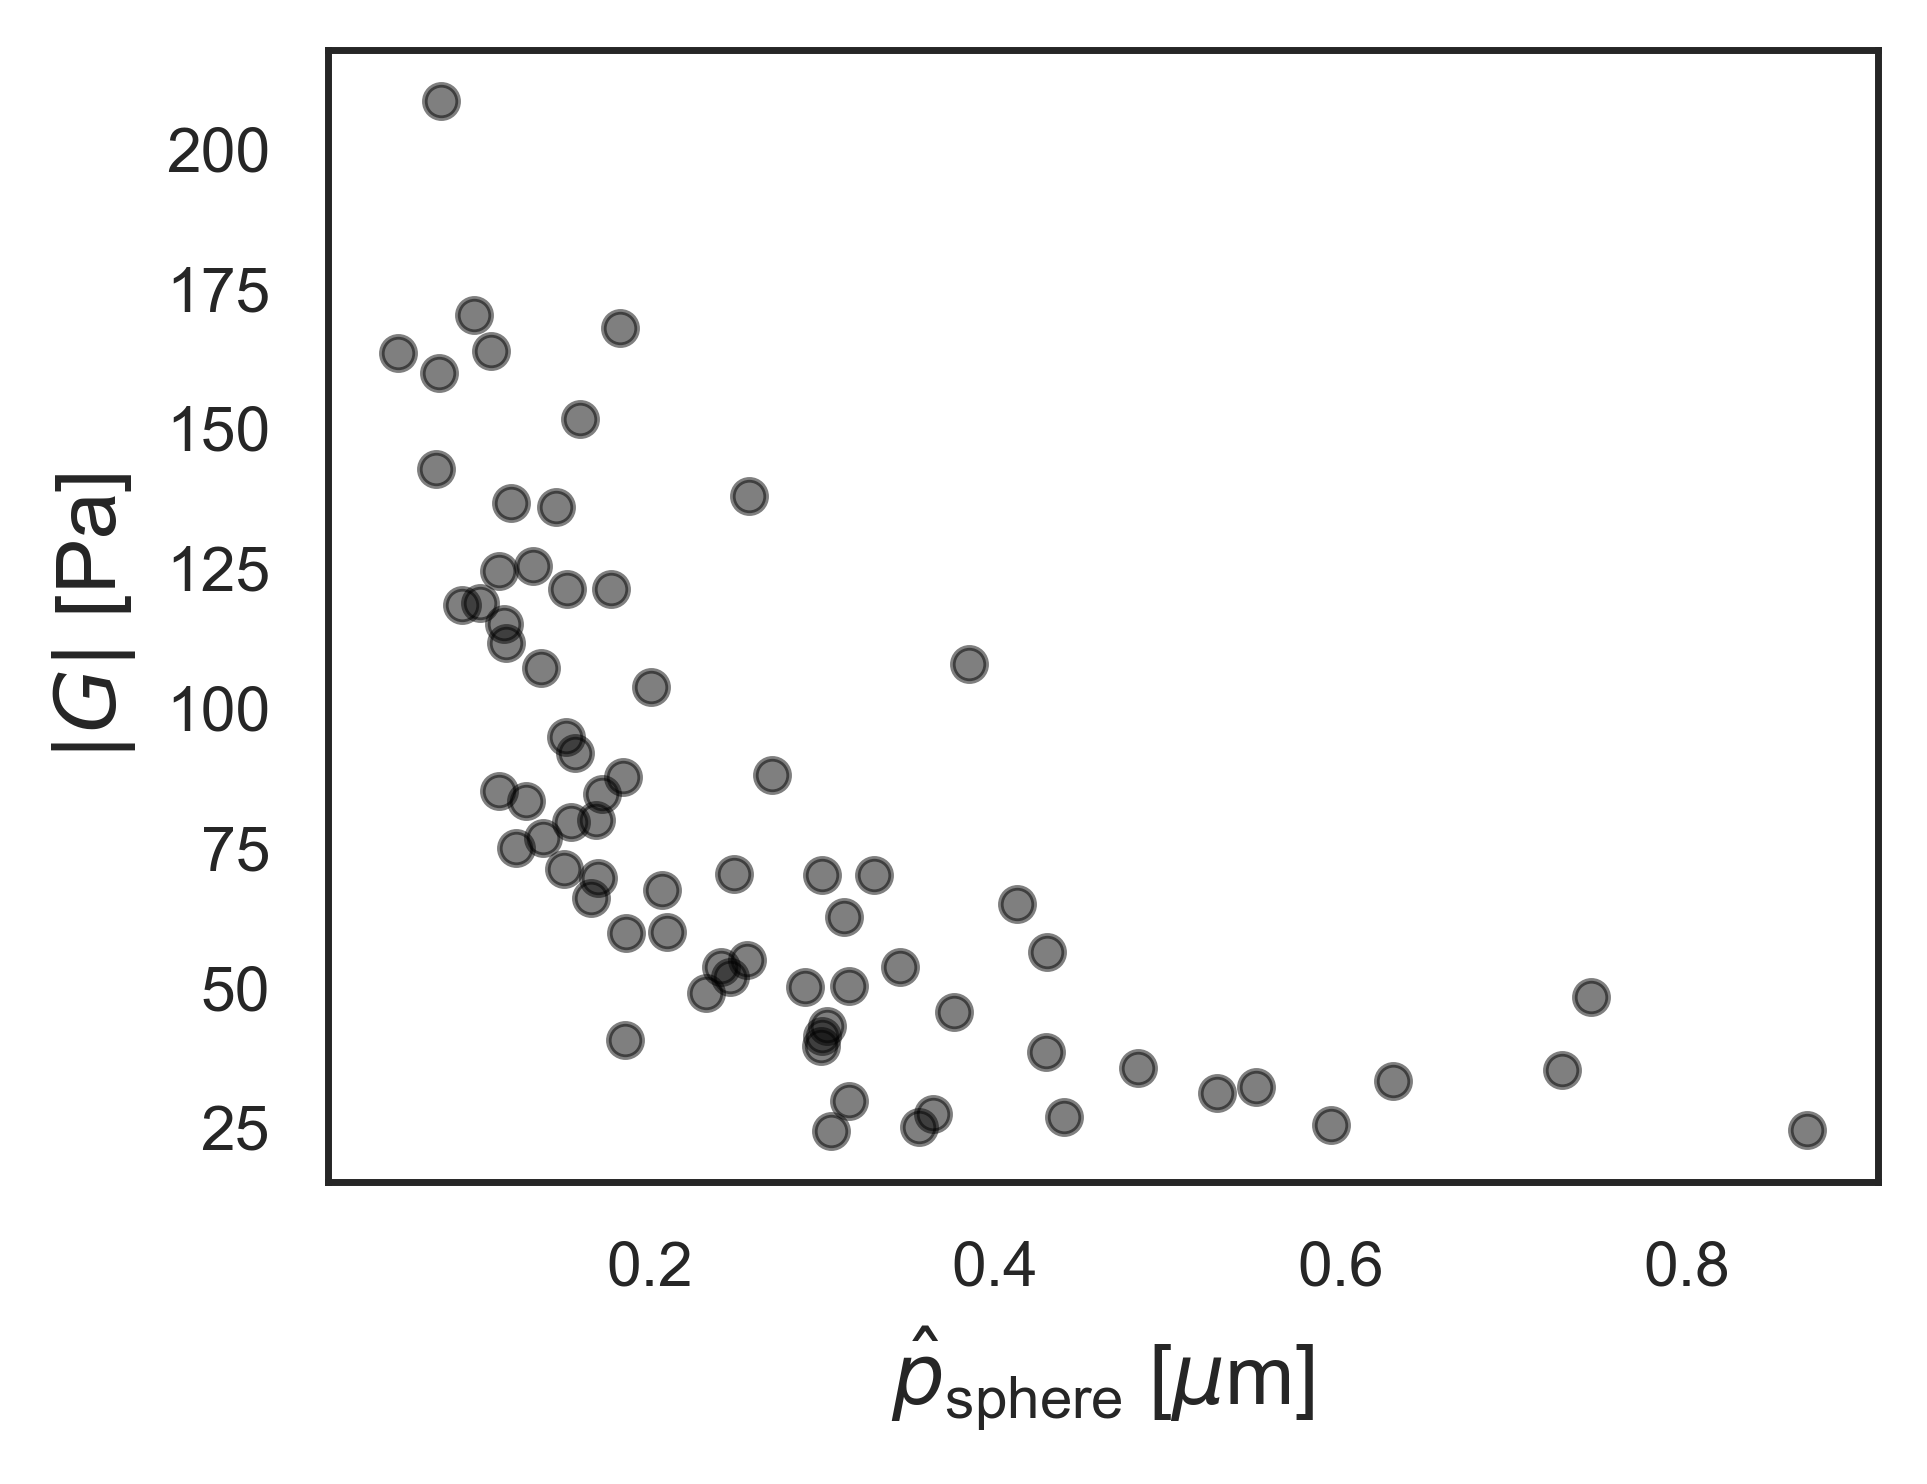

In [21]:
##supplementary |G|(\hat{p})

fig = plt.figure( figsize=(4,3),dpi = 500)
plt.scatter(y= low_Agarose["G_abs"],x=low_Agarose["a_(um)"],color='black',alpha=0.5)
plt.ylabel(r'$|G|$ [Pa]', fontsize=12)
plt.xlabel(r"$\hat{p}_\mathregular{sphere}$ [$\mu$m]", fontsize=12)
plt.tick_params(labelsize=9)

saver(fig,"disps_vs_G.png")

plt.show()


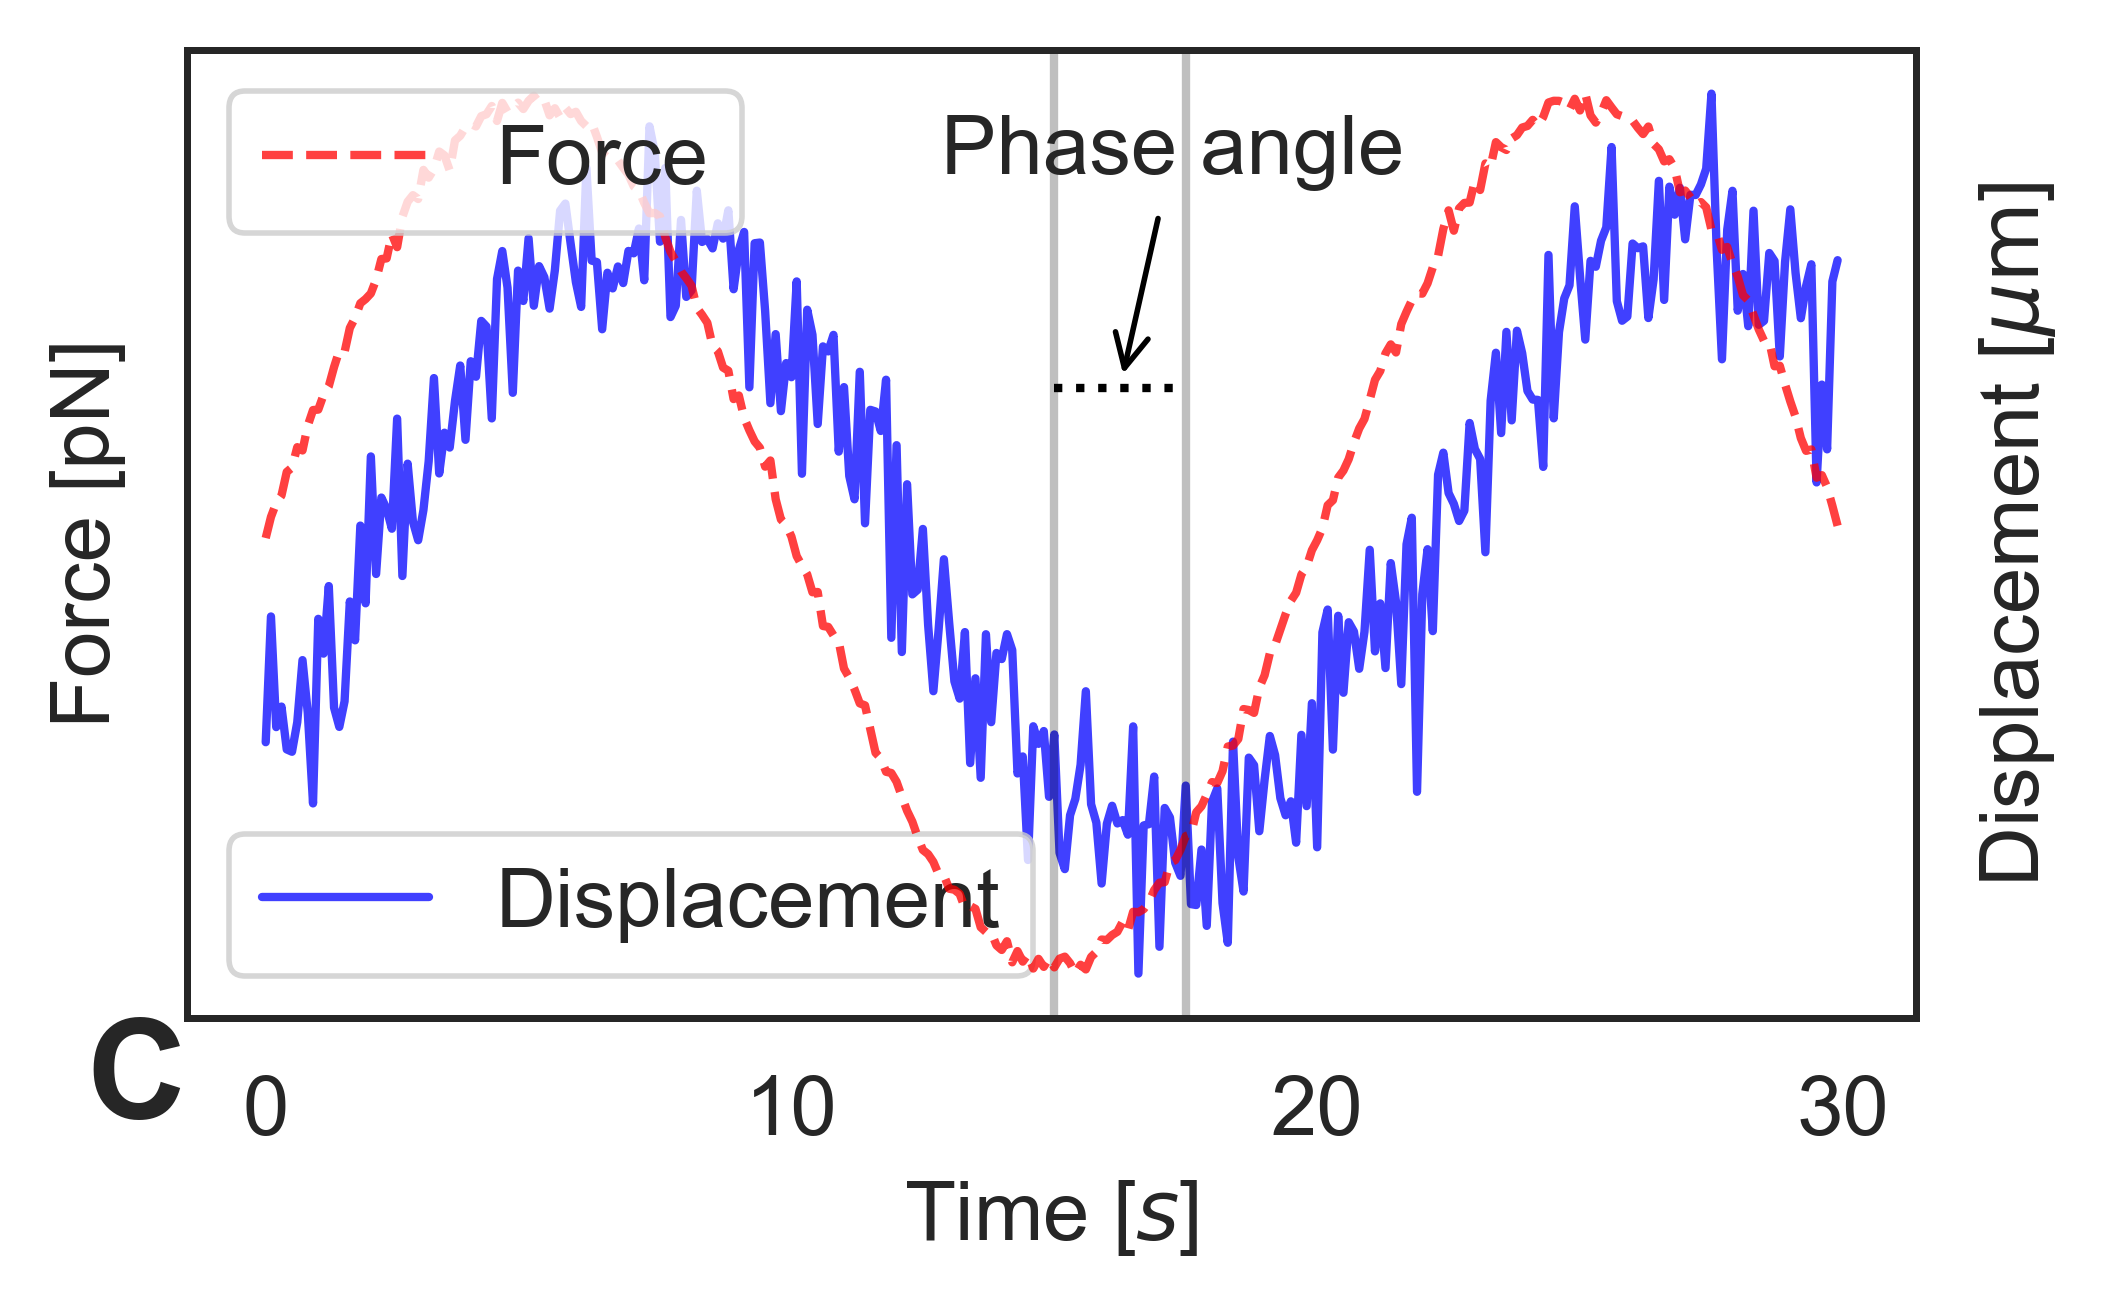

In [22]:
amplitude = 0.5
phase = -0.4
f=0.05
t=np.arange(-1,29,1e-1)
t2=np.arange(0,30,1e-1)
error =np.random.normal(0, 0.1,len(t))
error_2 =np.random.normal(0, 0.0075,len(t2))
displacment = amplitude*np.sin(2*np.pi*f*t+phase)+error
current = amplitude*np.sin(2*np.pi*f*t2)+error_2

fig, ax1 = plt.subplots(constrained_layout=True, figsize=(4.1, 2.5),dpi = 500)

ax1.set_xlabel(r"time [s]", fontsize=12)
ax1.set_ylabel(r"Force [pN]", fontsize=12)
ax1.tick_params(labelsize=12)
ax1.text(0, 0, "C", transform=ax1.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')
ax2_twin = ax1.twinx()
ax1.plot(t+np.abs(t[0]),displacment,label = "Displacement", color = "blue",alpha = 0.75)
ax1.axvline(x=15, color = "black",alpha = 0.25)
ax1.hlines(y = 0.25,xmin = 15, xmax = 17.5, colors = "black", linestyle = "dotted")

ax1.annotate(r'Phase angle', xy=(16.25, 0.25), xytext=(12.85, 0.6),fontsize=12,
            arrowprops=dict(arrowstyle="->",color='black'))

ax2_twin.plot(t2,current, label = "Force", color = "red",alpha = 0.75, linestyle = "dashed")
ax1.set_yticks([])
ax2_twin.set_yticks([])
ax1.set_xlabel(r"Time [$s$]", fontsize = 12)
ax2_twin.axvline(x=17.5,color = "black",alpha = 0.25)

ax2_twin.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2_twin.set_xlabel(r"Time [s]", fontsize=12)
ax2_twin.set_ylabel(r"Displacement [$\mu \rm{m}$]", fontsize=12)
ax2_twin.legend(["Force"], loc='upper left',fontsize = 12)
ax1.legend(["Displacement"], loc='lower left',fontsize = 12)
ax2_twin.tick_params(labelsize=12)
saver(fig,"test_2.png")

In [23]:
#Comsol Simulation
#ComsolPaperReview.csv
#df = pd.read_csv("C:/Users/lehtona6/Dropbox (Aalto)/ArttuFolder_PokkiLab/Shared_Materials/ExampleData/simulation/WorkSpace.csv",skiprows=[0],header=None)
#df_B = pd.read_csv("C:/Users/lehtona6/Dropbox (Aalto)/ArttuFolder_PokkiLab/Shared_Materials/ExampleData/simulation/ComsolPaperReviewB.csv",skiprows=[0],header=None)
df = pd.read_csv("C:/Users/lehtona6/Dropbox (Aalto)/ArttuFolder_PokkiLab/Shared_Materials/ExampleData/simulation/ComsolPaperReviewdB.csv",skiprows=[0],header=None)

headers = ["x","y"]
#headersB = ["x","y"]

for i in np.arange(2,len(df.columns)):
    if i%2 == 0:
        headers.append("Bz_{}".format(int(((i-2)*1/2))))
#        headersB.append("Bz_{}".format(int(((i-2)*1/2))))
    else:
        headers.append("Br_{}".format(int((i-2-1)*1/2))) # -2 x,y columns and -1 same timestamp as previous
#        headersB.append("Br_{}".format(int((i-2-1)*1/2))) # -2 x,y columns and -1 same timestamp as previous
        
df.columns = headers
#df_B.columns = headersB


In [24]:
from scipy.ndimage import gaussian_filter

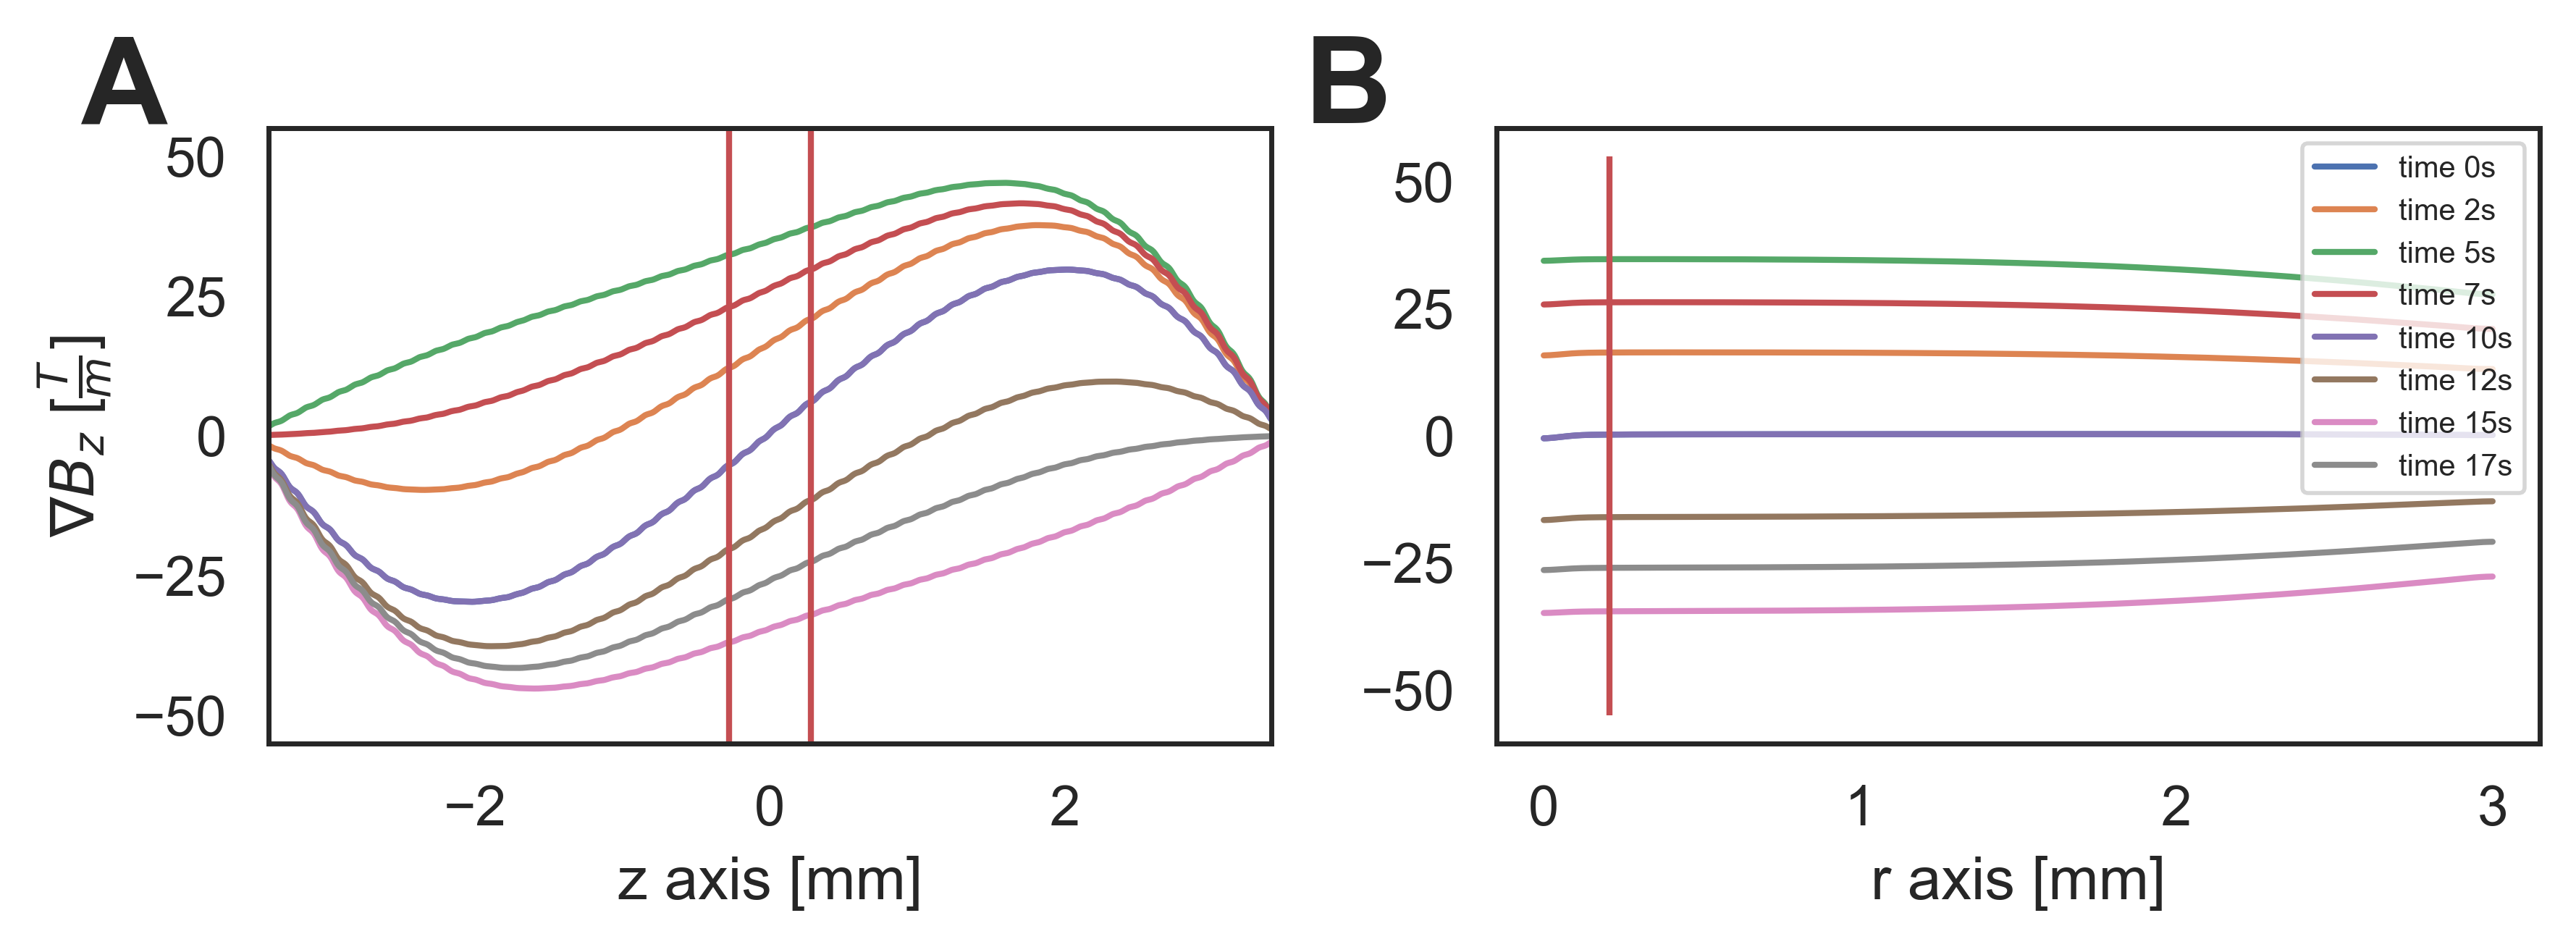

In [25]:
#Heterogenity quantification |G| ja \phi
fig = plt.figure(constrained_layout=True,figsize=(7, 2.5),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, width_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 1)
ax2 = subfigs[1].subplots(1, 1)

#ax3 = subfigs[1,0].subplots(1, 1)
#ax4 = subfigs[1,1].subplots(1, 1)

counter = 0
for i in headers[2:]:
    if counter in [0,2,5,7,10,12,15,17]:
        if i.split("_")[0] == "Bz":
            ax1.plot(df[df["x"]== 0]["y"]*1000,gaussian_filter(df[df["x"]== 0][i],3), label = "time {}s".format(i.split("_")[1]))
            ax2.plot(df[df["y"]== 0]["x"]*1000,gaussian_filter(df[df["y"]== 0][i],5), label = "time {}s".format(i.split("_")[1]))
            
#            ax3.plot(df_B[df_B["x"]== 0]["y"]*1000,gaussian_filter(df_B[df_B["x"]== 0][i],3), label = "time {}s".format(i.split("_")[1]))
#            ax4.plot(df_B[df_B["y"]== 0]["x"]*1000,gaussian_filter(df_B[df_B["y"]== 0][i],5), label = "time {}s".format(i.split("_")[1]))
        else:
            #ax2.plot(df[df["y"]== 0]["x"]*1000,df[df["y"]== 0][i], label = "time {}s".format(i.split("_")[1]))
            counter += 1
    else:
        #ax2.plot(-df[df["y"]== 0]["x"]*1000,df[df["y"]== 0][i], label = None)
        counter += 0.5

#ax1.set_title(r'$\nabla B_z$ between core cross-section',fontsize = 12)

ax1.set_ylim([-55,55])
ax1.vlines(1032*0.27e-3,-55,55,color="r")
ax1.vlines(-1032*0.27e-3,-55,55,color="r")
ax1.set_xlim([-0.0034*1000,0.0034*1000])
ax1.set_xlabel("z axis [mm]",fontsize = 12)
ax1.set_ylabel(r'$\nabla B_z$ [$\frac{T}{m}$]', fontsize = 12)

#ax2.set_title(r'$\nabla B_z$ along core cross-section',fontsize = 12)
ax2.set_xlabel("r axis [mm]",fontsize = 12)
#ax2.set_ylabel(r'$\nabla B_z$ [$\frac{kg}{ms^2A}$]',fontsize = 12)
ax2.vlines(772*0.27e-3,-55,55,color="r")
#ax2.set_ylim([-35,35])
ax2.legend(loc=1, prop={'size': 6})

ax1.text(-0.1, 1.15, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.15, "B", transform=ax2.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')


#ax3.set_ylim([0,0.4])
#ax3.vlines(1032*0.27e-3,-55,55,color="r")
#ax3.vlines(-1032*0.27e-3,-55,55,color="r")
#ax3.set_xlim([-0.0034*1000,0.0034*1000])
#ax3.set_xlabel("z axis [mm]",fontsize = 12)
#ax3.set_ylabel(r'$\nabla B_z$ [ $T$ ]', fontsize = 12)

#ax4.set_ylim([0,0.4])
#ax2.set_title(r'$\nabla B_z$ along core cross-section',fontsize = 12)
#ax4.set_xlabel("r axis [mm]",fontsize = 12)
#ax2.set_ylabel(r'$\nabla B_z$ [$\frac{kg}{ms^2A}$]',fontsize = 12)
#ax4.vlines(772*0.27e-3,-55,55,color="r")
#ax2.set_ylim([-35,35])
#ax4.legend(loc=1, prop={'size': 6})

#ax3.text(-0.1, 1.15, "C", transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
#ax4.text(-0.1, 1.15, "D", transform=ax4.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')

data_folder = "C:/Users/lehtona6/Dropbox (Aalto)/ArttuFolder_PokkiLab/Shared_Materials/ExampleData/simulation"
res_path = join(data_folder,"simulation_dB.png")
fig.savefig(res_path,transparent=False,facecolor='white' )

plt.show()

#print(hetero_gen.groupby("type")["G_abs","phi_(deg)"].agg(["mean","std"]))
